https://www.kaggle.com/competitions/playground-series-s3e13/data?select=test.csv"

Cool solution
https://www.kaggle.com/code/davidcoxon/complete-eda-data-egineering-and-model-comparison

In [30]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold, cross_val_score

# Download latest version
!kaggle competitions download -c playground-series-s3e13

#
#path = Path (kagglehub.dataset_download("https://www.kaggle.com/competitions/playground-series-s3e13/data?select=test.csv"))
#print ("Path to dataset files:", path)
#data_set_name = Path ("Titanic-Dataset.csv")
#s0 = pd.read_csv(path / data_set_name, header=None)
#s0

playground-series-s3e13.zip: Skipping, found more recently modified local copy (use --force to force download)


In [31]:
import zipfile 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import random
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, precision_score

from Common import *
# Extract all contents of the ZIP file

def vbpd_attributes():
    
    with zipfile.ZipFile("playground-series-s3e13.zip", 'r') as zip_ref:
        zip_ref.extractall("playground-series-s3e13")

    print("Files extracted successfully!")

    test_name = Path ("test.csv")
    train_name = Path ("train.csv")

    test = pd.read_csv( "playground-series-s3e13" / test_name )
    train = pd.read_csv( "playground-series-s3e13" / train_name )

    random_seed = 32
    random.seed(random_seed)

    y = train["prognosis"]
    #y = y.to_frame()
    X = train.drop (columns = ["prognosis"])

    X = X.drop (columns = ["id"])

    X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=random_seed)

    # Label encoding
    label_encoder = LabelEncoder()
    label_encoder.fit(y)  # Fit on the entire 'prognosis' column

    y_train = label_encoder.transform(y_train)
    y_test = label_encoder.transform(y_test)

    y_train = y_train.squeeze()

    print("Shapes:")
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("y_train:", y_train.shape)
    print("y_test:", y_test.shape)

    return X_train,X_test,y_train,y_test, label_encoder

X_train, X_test, y_train, y_test, label_encoder = vbpd_attributes()




Files extracted successfully!
Shapes:
X_train: (565, 64)
X_test: (142, 64)
y_train: (565,)
y_test: (142,)


In [32]:
from sklearn.metrics import accuracy_score, make_scorer

param_grid = [
    {
        "classifier": [SVC()],
        "classifier__kernel": ["linear", "rbf"],
        "classifier__C": [0.1, 1, 10]
    },
    {
        "classifier": [RandomForestClassifier()],
        "classifier__n_estimators": [50, 100],
        "classifier__max_depth": [None, 5, 10],
        "classifier__min_samples_split": [2, 5]
    },
    {
        "classifier": [KNeighborsClassifier()],
        "classifier__n_neighbors": [3, 5, 7],
        "classifier__weights": ["uniform", "distance"]
    },
    {
        "classifier": [LogisticRegression(solver='saga', multi_class='ovr', max_iter=500)],
        "classifier__C": [0.1, 1, 10],
        "classifier__penalty": ["l1", "l2"]
    }
]

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)


pipeline = Pipeline([
    ("classifier", SVC())  # Placeholder classifier
])

scorer = make_scorer(accuracy_score)


grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,
    scoring=scorer,
    verbose=2,
    n_jobs=-1  # Use all available CPU cores
)


# Fit Grid Search
grid_search.fit(X_train, y_train)


results_df = pd.DataFrame(grid_search.cv_results_)
# Select and display key columns
results_df = results_df[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']]
results_df = results_df.sort_values(by='rank_test_score')

# Display the table
print("Grid Search Results:")
print(results_df)

# Optional: Pretty display in Jupyter or a file
results_df.to_csv("grid_search_results.csv", index=False)  # Save results to CSV file

# Print the best model and hyperparameters
print("Best Model:", grid_search.best_estimator_)
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

results_df.to_csv("grid_search_results.csv", index=False)
print("Results saved to grid_search_results.csv")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Grid Search Results:
                                               params  mean_test_score  \
7   {'classifier': RandomForestClassifier(), 'clas...         0.304425   
8   {'classifier': RandomForestClassifier(), 'clas...         0.302655   
3   {'classifier': SVC(), 'classifier__C': 1, 'cla...         0.293805   
15  {'classifier': RandomForestClassifier(), 'clas...         0.292035   
16  {'classifier': RandomForestClassifier(), 'clas...         0.290265   
13  {'classifier': RandomForestClassifier(), 'clas...         0.286726   
14  {'classifier': RandomForestClassifier(), 'clas...         0.284956   
17  {'classifier': RandomForestClassifier(), 'clas...         0.281416   
12  {'classifier': RandomForestClassifier(), 'clas...         0.281416   
10  {'classifier': RandomForestClassifier(), 'clas...         0.281416   
0   {'classifier': SVC(), 'classifier__C': 0.1, 'c...         0.281416   
5   {'classifier': SVC(), 'cl

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sys
sys.path.append(r"C:\Users\Arath\Especialidad\MachineLearning\Projects\Classification_TabularVectorBorneDiseaseDataSet")
from Common import csv_to_latex_table

# Fit Grid Search
tests = [[X_train, y_train], [X_test, y_test]]
labels = ["Training_Set", "Test_Set"]

precision_scorer = make_scorer(precision_score, average='macro', zero_division=0)
grid_search.scoring = precision_scorer
score = "Precision"
columns_to_keep = ['mean_test_score', 'rank_test_score', 'hyperparam_combination']
for test_sel, label in zip(tests, labels):


    grid_search.fit(test_sel[0], test_sel[1])

    # Convert GridSearchCV results to DataFrame
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Extract only relevant columns: hyperparameters and scores
    results_df = results_df[['params', 'mean_test_score', 'rank_test_score']]

    # Add a string representation of hyperparameter combinations for plotting
    results_df['classifier'] = results_df['params'].apply(lambda x: x['classifier'].__class__.__name__)
    results_df['hyperparam_combination'] = results_df['params'].apply(
        lambda x: re.sub("classifier", "", re.sub(r"[{}()_:]", "", str(x)))
    )
    # Sort results by rank
    results_df = results_df.sort_values(by='rank_test_score')
    
    results_df_table = results_df[columns_to_keep]
    results_df_table.to_csv("Hyperparametersresults"+ label +".csv", index=False)
    # Loop through unique classifiers to create separate plots

    csv_to_latex_table (results_df_table[columns_to_keep].head(), "Global_" + label.replace(" ", "_"))

    for clf in results_df['classifier'].unique():
        clf_results = results_df[results_df['classifier'] == clf]  # Filter results per classifier

        #clf_table = clf_table.reset_index(drop=True)

        # Plot table using Seaborn heatmap
        #clf_table = clf_results[['mean_test_score', 'rank_test_score', 'hyperparam_combination']]
        csv_to_latex_table (clf_results[columns_to_keep], clf + label.replace(" ", "_"))

        clf_results.to_csv(clf + ".csv", index=False)
        filename = f"{score} gridsearch_results_{clf}_{label.replace(' ', '_')}.png"
        # Plot using Seaborn
        plt.figure(figsize=(10, 8))
        ax = sns.barplot(
            x='mean_test_score', 
            y='hyperparam_combination', 
            hue='hyperparam_combination',  # Explicitly use 'hyperparam_combination' for hue
            data=clf_results, 
            palette="Reds_d", 
            legend=False  # Suppress the legend
        )
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.7, alpha=0.7)
        plt.xlim(0, clf_results['mean_test_score'].max() + 0.01)
        plt.title(f"GridSearch Results: {clf} ({label})")
        plt.xlabel("Mean Test Score")
        plt.ylabel("Hyperparameter Combination")
        #plt.show()
        plt.tight_layout()
        plt.savefig(filename, dpi=200)
        plt.close()

        plt.figure(figsize=(10, 8))
        ax = sns.barplot(
            x='mean_test_score', 
            y='hyperparam_combination', 
            hue='hyperparam_combination',  # Explicitly use 'hyperparam_combination' for hue
            data=results_df, 
            palette="Blues_d", 
            legend=False  # Suppress the legend
        )

        plt.xlim(0, clf_results['mean_test_score'].max() + 0.01)
        plt.title(f"GridSearch Results: {clf} ({label})")
        plt.xlabel("Mean Test Score")
        plt.ylabel("Hyperparameter Combination")
        #plt.show()
        plt.tight_layout()
        plt.savefig(label, dpi=200)
        plt.close()

    # Expand the 'params' dictionary column into separate columns
    params_df = pd.json_normalize(results_df['params'])

    # Combine expanded parameters with the original scores and ranks
    results_combined = pd.concat([params_df, results_df[['mean_test_score', 'rank_test_score']]], axis=1)

    # Sort the results by rank
    results_combined = results_combined.sort_values(by='rank_test_score')

    # Display the table
    #print(f"Expanded Hyperparameter Table ({label}):")
    #print(results_combined.head(10))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


PermissionError: [Errno 13] Permission denied: 'HyperparametersresultsTraining_Set.csv'

Best Parameters: {'classifier': RandomForestClassifier(), 'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Test Accuracy with Best Parameters: 0.3592
Test Precision with Best Parameters: 0.3412
Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0  0]
 [ 1  1  0  0  0  0  0  1  1  0  1]
 [ 0  0  6  0  0  1  0  1  5  4  0]
 [ 0  0  1  6  3  0  0  0  5  0  0]
 [ 1  0  0  2  3  1  0  0  1  1  1]
 [ 0  0  1  2  0  0  1  0  6  4  0]
 [ 0  4  0  0  0  0  1  3  3  0  2]
 [ 2  1  0  0  0  0  2 12  2  0  0]
 [ 0  2  2  2  0  1  2  2  5  0  0]
 [ 0  0  1  3  0  1  0  0  3  4  3]
 [ 1  0  0  0  0  1  1  0  1  1  3]]


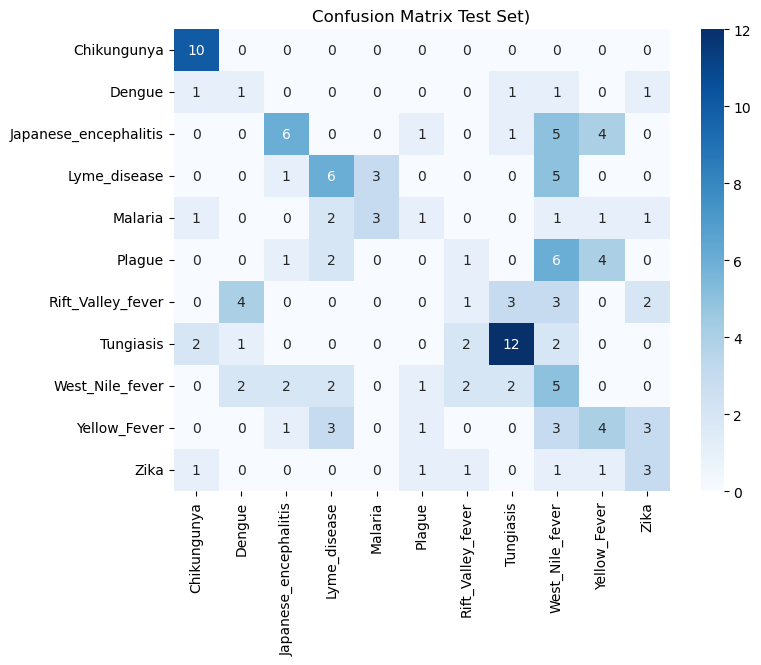

In [34]:

from sklearn.metrics import confusion_matrix


def print_mdl_metrics (x):
  return x
#
# Test set metrics
#
y_pred = grid_search.best_estimator_.predict(X_test)
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
test_precision = precision_score(y_test, best_model.predict(X_test), average='macro')

print("Best Parameters:", grid_search.best_params_)
print(f"Test Accuracy with Best Parameters: {test_score:.4f}")
print(f"Test Precision with Best Parameters: {test_precision:.4f}")


y_test_decoded = label_encoder.inverse_transform (y_test)
y_predict_decoded = label_encoder.inverse_transform (y_pred)

cm = confusion_matrix (y_test_decoded, y_predict_decoded, labels=label_encoder.classes_)

label = "Confusion_Matrix_Test_Set"
plt.figure(figsize=(8, 6))
plt.title(f"Confusion Matrix Test Set)")
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.savefig(label, dpi=200)
print ("Confusion Matrix:\n", cm)